Calibrate the TFR by fitting both galaxies in the Coma cluster and those used for 0-pt calibration simultaneously, weighting the galaxies by 1/$V_{max}$ and adjusting the Coma cluster properties as recommended by Anthony Carr.

In this notebook, we recompute $V_0$ with each recalibration (removing the "dwarf" galaxies - those below the line perpendicular to the current calibration that intersects the calibration at $M_r = -17$).

**Note**: This requires using a subclassed version of `hyperfit`.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.io import fits
from astropy.table import Table, unique, join
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, FlatLambdaCDM
from astropy import units as u
from astropy import constants as const
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from tqdm import tqdm

import os

import requests

import corner

import pickle

import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/DESI_SGA/TF/')
from help_functions import adjust_lightness
from line_fits import param_invert, hyperfit_line_multi
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Redrock systematic duplicate redshift uncertainty (from Lan+23)
# dv_sys = 7 # km/s
# dz_sys = dv_sys/c.value

# Data

## fuji

In [3]:
# tfuji_all = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/SGA-2020_fuji_Vrot.fits')
# tfuji_all = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/desi_pv_tf_fuji_healpix.fits')
# tfuji_all = Table.read('/Users/kdouglass/Documents/Research/data/DESI/SV/desi_pv_tf_fuji_healpix.fits')
# tfuji = unique(tfuji_all)

tfuji = Table.read('SGA-2020_fuji_Vrot_VI_dVsys_photsys_corr.fits')

tfuji[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,PHOTSYS
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407323,0.0054267743,0.0054291883,0.0051505533,0.005328927,0.005367155,0.005074676,0.005267603,0.0053163357,16.432898,0.27237165,3.4572394,5.399334,1.6520585,15.889806,0.2892297,2.7702796,4.85128,0.7334321,15.531683,0.31152296,2.403034,4.429238,0.75814104,0,0.0224279674032048,3.390920897207996e-05,63.81304014454741,23.986770443578123,S
1548,SG

### Update all Redrock uncertainties to account for 7 km/s statistical uncertainty

In [4]:
# tfuji['ZERR_MOD'] = np.sqrt(tfuji['ZERR']**2 + dz_sys**2)

## SGA

Read in our version of the SGA that includes distances from the Extragalactic Distance Database.  (This file was made with the `data_match.ipynb` notebook.)

In [5]:
# SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')
# SGA = Table.read('/Users/kellydouglass/Documents/Research/data/SGA/SGA-2020.fits', 'ELLIPSE')
SGA_dist = Table.read('../SGA_distances.fits')

SGA_dist[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,DM_Stellar,e_DM_lo_Stellar,e_DM_hi_Stellar,Stellar_Catalog,SN,DM1_SN,e_DM1_SN,DM2_SN,e_DM2_SN,DM3_SN,e_DM3_SN,DM4_SN,e_DM4_SN,DM5_SN,e_DM5_SN,DM6_SN,e_DM6_SN,DM7_SN,e_DM7_SN,SN_Catalog
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,bytes14,bytes21,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,bytes25
5002480,SGA-2020 5002480,DR8-2837p402-5033,-1,283.619631436471,40.3162008554537,DEV,178.80934,0.54342,0.3166,-1.0,24.29036,16.9862,False,DR8,530781,DR8-2837p402-5033,1,True,283.619631436471,40.3162008554537,0.54342,2837p402,283.6196056669463,40.316337272867564,0.53864765,SB26,179.53694,0.3690244,283.6194583471782,40.31653379127378,11.641381,11.157478,8.614751,9.8993,1.6142721,3.685578,5.5844307,7.701021,9.878292,11.927793,13.400182,14.697571,16.15943,21.37251,20.373438,19.779512,19.920574,19.005274,18.41066,19.314016,18.435898,17.843414,18.922651,18.076838,17.494484,18.664383,17.833265,17.25879,18.496494,17.682926,17.106598,18.404135,17.605488,17.02742,18.332602,17.555883,16.971588,18.299273,17.52499,16.931496,0.04933311,0.065890566,0.09742977,0.10495926,0.1614855,0.27832195,0.15179653,0.13904023,0.20484819,0.041657884,0.06669066,0.06785251,0.038538612,0.049561314,0.05101378,0.03635901,0.041818976,0.042013034,0.03367074,0.03763669,0.03705858,0.03122176,0.03420294,0.033616345,0.029198052,0.031941395,0.031132452,0.028080799,0.030865192,0.029955743,0.02722575,0.030135926,0.029090546,0.026788738,0.02959205,0.028436601,17.799881,1.3952494,

## Merge two tables

In [6]:
# Find unique columns in SGA_dist
SGA_dist_unique_cols = list(set(SGA_dist.colnames).difference(tfuji.colnames))

SGA = join(tfuji, SGA_dist[['SGA_ID'] + SGA_dist_unique_cols], keys='SGA_ID')
SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,PHOTSYS,e_DM1_SN,e_DM6_SN,e_DM_hi_Stellar,SN_Catalog,e_DM2_SN,DM1_SN,SN,Stellar_Catalog,DM2_SN,e_DM5_SN,e_DM3_SN,DM5_SN,DM7_SN,DM6_SN,DM_Stellar,e_DM4_SN,e_DM_lo_Stellar,DM3_SN,DM4_SN,e_DM7_SN
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,int64,float64,bytes25,float64,float64,bytes21,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.005550764,0.0052407

In [7]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## Separate the fuji data into center and off-center observations

In [7]:
tfuji['SKY_FIBER_DIST'] = 0.
tfuji['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in tqdm(np.unique(tfuji['SGA_ID'])):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tfuji['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tfuji['RA'][obs_idx], 
                             dec=tfuji['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tfuji['SKY_FIBER_DIST'][obs_idx] = sep2d
    tfuji['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

100%|██████████| 4524/4524 [00:14<00:00, 312.83it/s]


In [8]:
centers_boolean = tfuji['SKY_FIBER_DIST_R26'] < 0.1

fuji_centers = tfuji[centers_boolean]
fuji_axis = tfuji[~centers_boolean]

### Clean the fuji center observations

Only keep those with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [9]:
good_centers = fuji_centers[(fuji_centers['DELTACHI2'] > 25) & (fuji_centers['ZWARN'] == 0)]

### If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
rng = np.random.default_rng()

N_samples = 10000 # for large error propagation

In [12]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

# weights = 1./(good_centers['ZERR']**2)
weights = 1./(good_centers['ZERR_MOD']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(good_centers['ZERR_MOD'][obs_idx]/good_centers['Z'][obs_idx]) < 0.05):
        SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        z_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            z_random[i] = rng.normal(scale=good_centers['ZERR_MOD'][obs_idx][i], 
                                     loc=good_centers['Z'][obs_idx][i], 
                                     size=N_samples)
        
        avg_z_random = np.average(z_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['ZERR_DESI'][SGA_idx] = np.std(avg_z_random)

100%|██████████| 4255/4255 [00:01<00:00, 3572.44it/s]


## Compute the maximum volume for each galaxy

Since the SGA is a size-limited catalog ($D_{26} > 0.2$ arcmin), there is a maximum volume within which each galaxy could be lcoated to be included in the SGA.  Let's calculate that maximum volume so that we can use it as a weight in the TFR calibration.

In [8]:
# Planck18_h = LambdaCDM(H0=100, 
#                        Om0=Planck18.Om0, 
#                        Tcmb0=Planck18.Tcmb0, 
#                        Neff=Planck18.Neff, 
#                        m_nu=Planck18.m_nu, 
#                        Ob0=Planck18.Ob0, 
#                        Ode0=Planck18.Ode0)
Planck18_h = FlatLambdaCDM(H0=100, Om0=0.3151)

In [9]:
dist = Distance(z=np.abs(SGA['Z_DESI']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*SGA['D26']*u.arcmin)

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)

dist_max = Distance(z=0.1, cosmology=Planck18_h)

SGA['MAX_VOL_FRAC'] = SGA['DIST_MAX'].to('Mpc')**3 / dist_max.to('Mpc')**3

# Coma cluster membership

Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_v$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_v$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_v$ is the velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

In [10]:
# Data table #3 from Tully (2015)
hdu = fits.open('../Tully15-Table3.fits')
table3 = Table(hdu[1].data)
hdu.close()

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,<Vcmba>,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


In [11]:
# Data table from Kourkchi et al. (2017)
clusters_K = Table.read('../Kourkchi17-Table2.fits.gz')
clusters_K[:5]

PGC1,PGC1+,Nm,GLON,GLAT,SGLON,SGLAT,Ksmag,logK,HRV,VLS,Nd,Dist,e_Dist,sigmaL,sigmaV,R2t,Rg,logMK,logMd
,,,deg,deg,deg,deg,mag,[Lsun],km / s,km / s,,Mpc,%,km / s,km / s,Mpc,Mpc,[Msun],[Msun]
int32,int32,int16,float64,float64,float64,float64,float64,float64,int16,int16,int16,float64,int16,int16,int16,float64,float64,float64,float64
43296,43296,191,302.2241,21.6465,156.3251,-11.5819,4.61,12.71,3407,3142,59,36.96,3,595,800,1.612,0.893,14.624,14.717
46618,43296,30,307.8738,19.2865,159.6426,-6.8008,6.07,12.11,3340,3086,5,37.57,7,350,307,0.950,0.745,13.936,13.808
45174,43296,34,306.0424,32.5707,146.1941,-6.0422,6.42,11.96,3292,3059,4,44.03,8,307,300,0.833,0.693,13.764,13.756
40498,43296,24,297.5648,23.0823,153.9019,-15.4648,6.48,11.92,3258,2986,4,28.45,6,296,170,0.801,0.607,13.713,13.207
43557,43296,22,302.9333,36.4075,141.8602,-7.7062,6.82,11.81,3296,3066,7,39.89,8,267,163,0.724,0.428,13.582,13.017


In [12]:
# Is Coma in Kourkchi's data table?
Coma_nest = 100001

Coma_row_t3 = table3['Nest'] == Coma_nest

print(table3['PGC1'][Coma_row_t3] in clusters_K['PGC1'])

False


So we don't need to update any of the info from the Kourkchi table.

In [13]:
R2t_Coma = table3['R2t'][Coma_row_t3][0]
sigma_Coma = table3['sigV'][Coma_row_t3][0]
mu_Coma = table3['DM'][Coma_row_t3][0]

Coma_coords = SkyCoord(table3['SGLON'][Coma_row_t3]*u.degree, 
                       table3['SGLAT'][Coma_row_t3]*u.degree, 
                       frame='supergalactic').icrs

# Calculate heliocentric redshift of Coma
zHelio_Coma = convert_z_frame(table3['<Vcmba>'][Coma_row_t3][0]/c.value, 
                              Coma_coords.ra.deg, 
                              Coma_coords.dec.deg, 
                              corrtype='-full')[0]

In [14]:
V_Coma = 100 * 10**(0.2*(mu_Coma - 25)) / (1 + zHelio_Coma)
# Tully used H0 = 100 km/s/Mpc, which is why we are using 100 here and not H0

V_Coma

np.float64(7176.227154937464)

## Calculate the projected distance between the Coma cluster and each SGA galaxy

In [15]:
# First, we need to convert R2t from Mpc to an angle, using the group's velocity
# Note that we are NOT assuming that the size of the cluster is a small angle!!
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(V_Coma/H0)) * u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(V_Coma/H0)) * u.radian

In [16]:
SGA_coords = SkyCoord(SGA['RA'], SGA['DEC'], unit='deg')

sep = Coma_coords.separation(SGA_coords)

In [17]:
SGA_in_Coma1 = (sep < R2t_Coma_angle_1p5) & (SGA['Z_DESI']*c.value > V_Coma - 3*sigma_Coma) & (SGA['Z_DESI']*c.value < V_Coma + 3*sigma_Coma)

SGA_in_Coma2 = (sep >= R2t_Coma_angle_1p5) & (sep < R2t_Coma_angle_3) & (SGA['Z_DESI']*c.value > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c.value < V_Coma + 2*sigma_Coma)
#SGA_in_Coma2 = (sep >= 1.5*R2t_Coma_angle) & (SGA['Z_DESI']*c > V_Coma - 2*sigma_Coma) & (SGA['Z_DESI']*c < V_Coma + 2*sigma_Coma)

SGA_in_Coma = SGA_in_Coma1 | SGA_in_Coma2

################################################################################
# Keep all observations of each galaxy that are within the Coma cluster
#-------------------------------------------------------------------------------
SGA_ID_in_Coma = SGA['SGA_ID'][SGA_in_Coma]

# centers_inComa = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_Coma)]

# axis_inComa = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_in_Coma)]
################################################################################

# print('fuji galaxies in Coma with good center observations:', len(np.unique(centers_inComa['SGA_ID'])))
# print('fuji off-center observations in Coma:', len(axis_inComa))
print('fuji galaxies in Coma:', len(SGA_ID_in_Coma))

fuji galaxies in Coma: 100


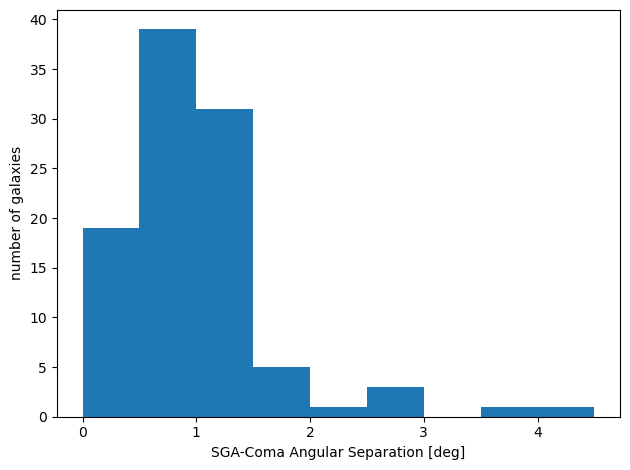

In [18]:
plt.figure(tight_layout=True)

plt.hist(sep[SGA_in_Coma].to_value('degree'), bins=np.arange(0, 5, 0.5))

plt.xlabel('SGA-Coma Angular Separation [deg]')
plt.ylabel('number of galaxies');

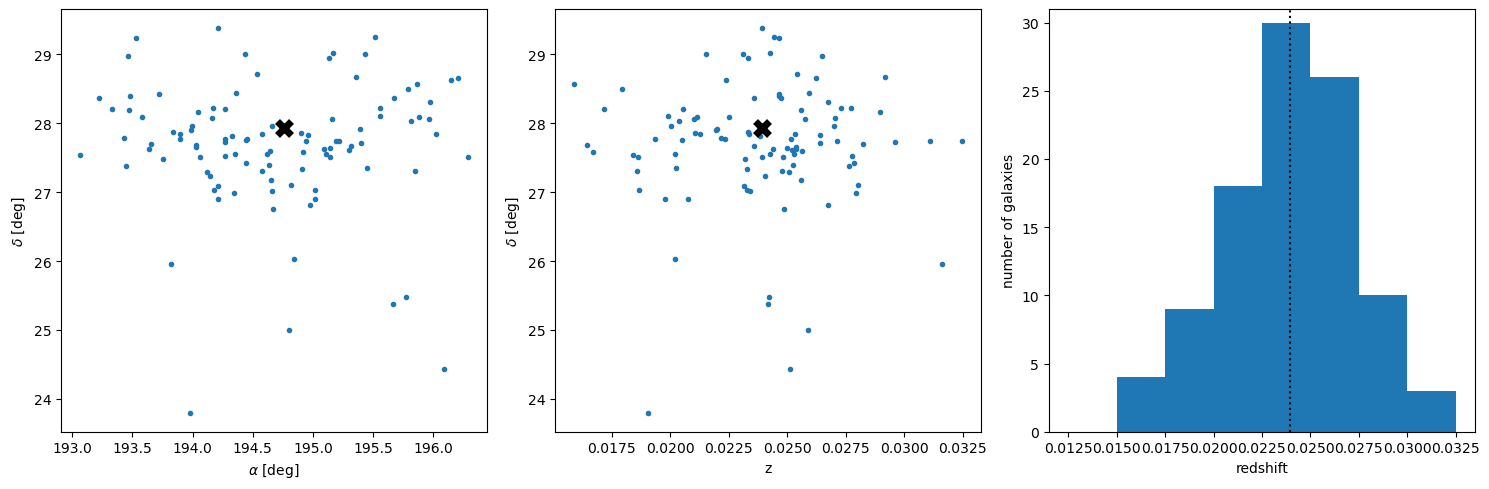

In [19]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
# plt.plot(centers_inComa['TARGET_RA'], centers_inComa['TARGET_DEC'], '.')
plt.plot(SGA['RA'][SGA_in_Coma], SGA['DEC'][SGA_in_Coma], '.')
plt.plot(Coma_coords.transform_to('icrs').ra.deg, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(132)
# plt.plot(centers_inComa['Z'], centers_inComa['TARGET_DEC'], '.')
plt.plot(SGA['Z_DESI'][SGA_in_Coma], SGA['DEC'][SGA_in_Coma], '.')
plt.plot(V_Coma/c.value, Coma_coords.transform_to('icrs').dec.deg, 'kx', ms=10, mew=5)
plt.xlabel('z')
plt.ylabel(r'$\delta$ [deg]')

plt.subplot(133)
# plt.hist(centers_inComa['Z'], bins=np.arange(0.0125, 0.035, 0.0025))
plt.hist(SGA['Z_DESI'][SGA_in_Coma], bins=np.arange(0.0125, 0.035, 0.0025))
plt.vlines(V_Coma/c.value, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=31);

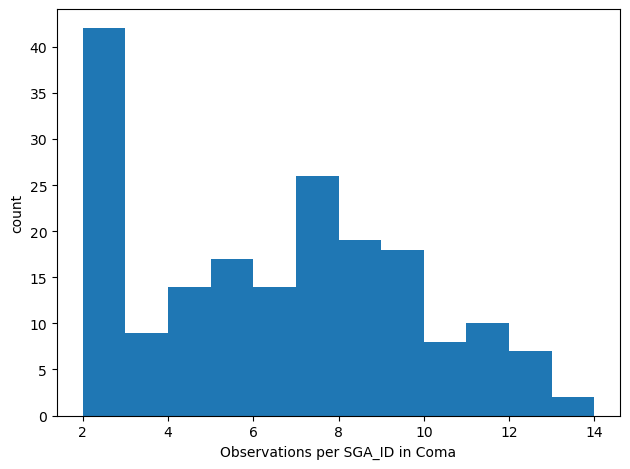

In [25]:
axis_SGAids, axis_counts = np.unique(axis_inComa['SGA_ID'], return_counts=True)
center_SGAids, center_counts = np.unique(centers_inComa['SGA_ID'], return_counts=True)

counts = []

for sga_id in SGA_ID_in_Coma:
    
    center_count = 0
    axis_count = 0
    
    if sga_id in center_SGAids:
        
        center_count = center_counts[center_SGAids == sga_id]
        
    if sga_id in axis_SGAids:
        
        axis_count = axis_counts[axis_SGAids == sga_id]
        
    count = center_count + axis_count
    
    if count > 1:
        
        counts.append(count)
        

plt.figure(tight_layout=True)

plt.hist(np.array(counts), bins=np.arange(2,15))

plt.xlabel('Observations per SGA_ID in Coma')
plt.ylabel('count');

# 0-pt calibrators

Which objects with center observations also have independent distances?

In [20]:
distances = (SGA['DM_Stellar'] != -1) | (SGA['DM1_SN'] != -1) #| np.isfinite(SGA['DM_PantheonSH0ES'])
centers = np.isfinite(SGA['Z_DESI'])

################################################################################
# Keep all observations of each galaxy that have independent distances
#-------------------------------------------------------------------------------
SGA_ID_dist = SGA['SGA_ID'][distances & centers]

# centers_dist = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_dist)]

# axis_dist = fuji_axis[np.in1d(fuji_axis['SGA_ID'], SGA_ID_dist)]
################################################################################

# print('fuji galaxies with distances and good center observations:', len(np.unique(centers_dist['SGA_ID'])))
# print('fuji off-center observations in galaxies with distances:', len(axis_dist))
print('fuji galaxies with distances and rotational velocities:', len(SGA_ID_dist))

fuji galaxies with distances and rotational velocities: 7


In [21]:
SGA_ID_dist

294387
464075
464075
464075
464075
464075
630029


In [22]:
# Some galaxies have multiple measures of the distance.
# Is there a single source that has an estimate for all of them?
SGA['SGA_ID', 'SN_Catalog'][distances & centers]

SGA_ID,SN_Catalog
int64,bytes25
294387,Stahl-SNIa
464075,Constitution-SNIa
464075,5-Sources-SNIa
464075,Stahl-SNIa
464075,Union2-SNIa
464075,LOSS-Ganeshalingam13-SN1a
630029,Stahl-SNIa


They all have Stahl-SNIa distance moduli!  So we'll just use those distances.

In [23]:
Stahl = SGA['SN_Catalog'] == 'Stahl-SNIa'

SGA_ID_dist_Stahl = SGA['SGA_ID'][distances & centers & Stahl]

print('fuji galaxies with rotational velocities and distances from Stahl:', len(SGA_ID_dist_Stahl))

fuji galaxies with rotational velocities and distances from Stahl: 3


# Calculate the rotational velocity

## For Coma galaxies

In [27]:
axis_inComa['V_ROT'] = np.nan
axis_inComa['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_inComa['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = SGA['Z_DESI'][sga_idx]
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # axis_inComa['V_ROT'][obs_idx] = c*(axis_inComa['Z'][obs_idx] - z_center)
    z_rot = (1 + axis_inComa['Z'][obs_idx])/(1 + z_center) - 1
    axis_inComa['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(axis_inComa['ZERR_MOD'][obs_idx]/axis_inComa['Z'][obs_idx]) < 0.05) and (np.abs(z_err_center/z_center) < 0.05):
        # axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_inComa['ZERR'][obs_idx]**2 + z_err_center**2)
        # axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_inComa['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis_inComa['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
        axis_inComa['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_inComa['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis_inComa['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(scale=z_err_center, 
                                     loc=z_center, 
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(scale=axis_inComa['ZERR_MOD'][obs_idx][i], 
                                          loc=axis_inComa['Z'][obs_idx][i], 
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        axis_inComa['V_ROT_ERR'][obs_idx] = np.std(c*z_rot_random, axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_inComa['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

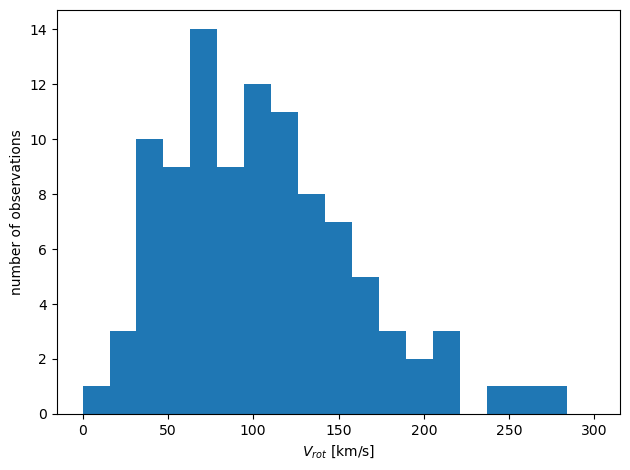

In [24]:
plt.figure(tight_layout=True)

# plt.hist(np.abs(axis_inComa['V_ROT']), bins=np.linspace(0, 1000, 100))
plt.hist(SGA['V_0p33R26'][SGA_in_Coma], bins=np.linspace(0, 300, 20))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

## For 0-pt calibrators

In [29]:
axis_dist['V_ROT'] = np.nan
axis_dist['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_dist['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center = SGA['ZERR_DESI'][sga_idx]

    # Calculate rotational velocity for all observations of the galaxy
    # axis_dist['V_ROT'][obs_idx] = c*(axis_dist['Z'][obs_idx] - z_center)
    z_rot = (1 + axis_dist['Z'][obs_idx])/(1 + z_center) - 1
    axis_dist['V_ROT'][obs_idx] = c*z_rot

    # Calculate uncertainty in the rotational velocity
    if np.all(np.abs(axis_dist['ZERR_MOD'][obs_idx]/axis_dist['Z'][obs_idx]) < 0.05) and (np.abs(z_err_center/z_center) < 0.05):
        # axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis_dist['ZERR'][obs_idx]**2 + z_err_center**2)
        # axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_dist['ZERR'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis_dist['Z'][obs_idx])/(1 + z_center)**2) + (dv_sys/c).value**2)
        axis_dist['V_ROT_ERR'][obs_idx] = c*np.sqrt((axis_dist['ZERR_MOD'][obs_idx]/(1 + z_center))**2 + z_err_center**2*((1 + axis_dist['Z'][obs_idx])/(1 + z_center)**2))
    else:
        z_center_random = rng.normal(scale=z_err_center, 
                                     loc=z_center, 
                                     size=N_samples)

        z_axis_random = np.zeros((np.sum(obs_idx), N_samples))

        for i in range(np.sum(obs_idx)):
            z_axis_random[i] = rng.normal(scale=axis_dist['ZERR_MOD'][obs_idx][i], 
                                          loc=axis_dist['Z'][obs_idx][i],
                                          size=N_samples)

        z_rot_random = (1 + z_axis_random)/(1 + z_center_random) - 1

        axis_dist['V_ROT_ERR'][obs_idx] = np.std(c*z_rot_random, axis=1)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis_dist['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

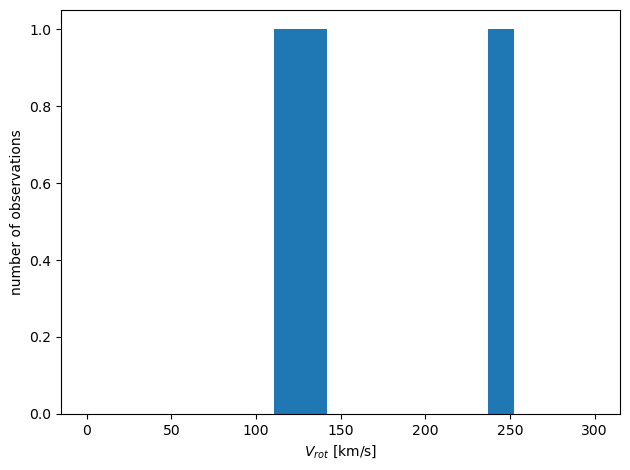

In [25]:
plt.figure(tight_layout=True)

# plt.hist(np.abs(axis_dist['V_ROT']), bins=np.linspace(0, 1000, 100))
plt.hist(SGA['V_0p33R26'][distances & centers & Stahl], bins=np.linspace(0, 300, 20))

plt.xlabel('$V_{rot}$ [km/s]')
plt.ylabel('number of observations');

# Cut for galaxies suitable for calibrating the TFR

Requirements:
 * $10 < V_{rot} < 1000$ km/s at $0.33R_{26}$
 * $\Delta V / V_{min} \leq 5$
 * Consistent velocity sign
 * $i > 45^\circ$
 * Spiral-type morphology
 * Passes visual inspection

The first three are already taken care of, as well as the VI.

## Velocity cut

In [31]:
r0p3 = (axis_inComa['SKY_FIBER_DIST_R26'] > 0.3) & (axis_inComa['SKY_FIBER_DIST_R26'] < 0.4)

Vgood = (np.abs(axis_inComa['V_ROT']) < 1000) & (np.abs(axis_inComa['V_ROT']) > 10)

good_axis_inComa = axis_inComa[r0p3 & Vgood]

print(len(good_axis_inComa), len(np.unique(good_axis_inComa['SGA_ID'])))

190 111


In [32]:
r0p3_0pt = (axis_dist['SKY_FIBER_DIST_R26'] > 0.3) & (axis_dist['SKY_FIBER_DIST_R26'] < 0.4)

Vgood_0pt = (np.abs(axis_dist['V_ROT']) < 1000) & (np.abs(axis_dist['V_ROT']) > 10)

good_axis_dist = axis_dist[r0p3_0pt & Vgood_0pt]

print(len(good_axis_dist), len(np.unique(good_axis_dist['SGA_ID'])))

7 3


## Relative velocity cut

In [33]:
good_deltaV = np.ones(len(good_axis_inComa), dtype=bool)

for sga_id in np.unique(good_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_inComa['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_inComa['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_inComa['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_inComa['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_inComa['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_inComa['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_inComa['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False

In [34]:
good_deltaV_axis_inComa = good_axis_inComa[good_deltaV]

print(len(good_deltaV_axis_inComa), len(np.unique(good_deltaV_axis_inComa['SGA_ID'])))

182 108


In [35]:
good_deltaV_0pt = np.ones(len(good_axis_dist), dtype=bool)

for sga_id in np.unique(good_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_axis_dist['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(good_axis_dist['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(good_axis_dist['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(good_axis_dist['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = good_axis_dist['DELTACHI2'] >= 25
            
            good_deltaV_0pt[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(good_axis_dist['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(good_axis_dist['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV_0pt[good_obs_idx] = False

In [36]:
good_deltaV_axis_dist = good_axis_dist[good_deltaV_0pt]

print(len(good_deltaV_axis_dist), len(np.unique(good_deltaV_axis_dist['SGA_ID'])))

7 3


## Inclination angle cut

In [26]:
SGA['cosi2'] = (SGA['BA']**2 - q0**2)/(1 - q0**2)
SGA['cosi2'][SGA['cosi2'] < 0] = 0

i_min = 45. # degrees
cosi2_max = np.cos(i_min*np.pi/180.)**2

In [38]:
good_deltaV_axis_inComa['iSGA'] = -1

for i in range(len(good_deltaV_axis_inComa)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_inComa['SGA_ID'][i]]
    
    good_deltaV_axis_inComa['iSGA'][i] = sga_idx
    
good_deltaV_axis_inComa['cosi2'] = SGA['cosi2'][good_deltaV_axis_inComa['iSGA']]

In [27]:
# edge = good_deltaV_axis_inComa['cosi2'] <= cosi2_max
edge = SGA['cosi2'] <= cosi2_max

# good_edge_axis_inComa = good_deltaV_axis_inComa[edge]
good_edge_axis_inComa = SGA[SGA_in_Coma & edge]

# print(len(good_edge_axis_inComa), len(np.unique(good_edge_axis_inComa['SGA_ID'])))
print(len(good_edge_axis_inComa))

81


In [40]:
good_deltaV_axis_dist['iSGA'] = -1

for i in range(len(good_deltaV_axis_dist)):
    
    # Find galaxy in SGA
    sga_idx = SGA_dict[good_deltaV_axis_dist['SGA_ID'][i]]
    
    good_deltaV_axis_dist['iSGA'][i] = sga_idx
    
good_deltaV_axis_dist['cosi2'] = SGA['cosi2'][good_deltaV_axis_dist['iSGA']]

In [28]:
# edge_0pt = good_deltaV_axis_dist['cosi2'] <= cosi2_max

# good_edge_axis_dist = good_deltaV_axis_dist[edge_0pt]
good_edge_axis_dist = SGA[distances & centers & Stahl & edge]

# print(len(good_edge_axis_dist), len(np.unique(good_edge_axis_dist['SGA_ID'])))
print(len(good_edge_axis_dist))

2


## Morphology cut

In [42]:
good_edge_axis_inComa['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_inComa['iSGA']]

In [29]:
spirals = np.zeros(len(good_edge_axis_inComa), dtype=bool)

for i in range(len(good_edge_axis_inComa)):
    
    try:    
        if (good_edge_axis_inComa['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_inComa['MORPHTYPE'][i][:2] != 'S0'):
            spirals[i] = True
    except IndexError:
        print(good_edge_axis_inComa['MORPHTYPE'][i])

good_edge_spirals_axis_inComa = good_edge_axis_inComa[spirals]

print(len(good_edge_spirals_axis_inComa))#, len(np.unique(good_edge_spirals_axis_inComa['SGA_ID'])))

--
39


In [44]:
good_edge_axis_dist['MORPHTYPE'] = SGA['MORPHTYPE'][good_edge_axis_dist['iSGA']]

In [30]:
spirals_0pt = np.zeros(len(good_edge_axis_dist), dtype=bool)

for i in range(len(good_edge_axis_dist)):
    
    try:    
        if (good_edge_axis_dist['MORPHTYPE'][i][0] == 'S') and (good_edge_axis_dist['MORPHTYPE'][i][:2] != 'S0'):
            spirals_0pt[i] = True
        elif good_edge_axis_dist['MORPHTYPE'][i] == 'N/A':
            spirals_0pt[i] = True
    except IndexError:
        print(good_edge_axis_dist['MORPHTYPE'][i])

good_edge_spirals_axis_dist = good_edge_axis_dist[spirals_0pt]

print(len(good_edge_spirals_axis_dist))#, len(np.unique(good_edge_spirals_axis_dist['SGA_ID'])))

2


## Visual inspection cut

This removes any observations that are contaminated by foreground stars or other galaxies.

In [56]:
def get_cutout(targetid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/coma_{}.jpg'.format(targetid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [57]:
for sga_id in np.unique(good_edge_spirals_axis_inComa['SGA_ID']):
    
    tf_list = good_edge_spirals_axis_inComa[good_edge_spirals_axis_inComa['SGA_ID'] == sga_id]
    center_list = centers_inComa[centers_inComa['SGA_ID'] == sga_id]
    
    try:
        targetid = int(center_list['TARGETID'][0])
    except TypeError as err:
        print(err)
        # print(sga_galaxy['TARGETID'])
        continue
    
    ra, dec, z = float(SGA['RA'][SGA_dict[sga_id]]), float(SGA['DEC'][SGA_dict[sga_id]]), float(SGA['Z_DESI'][SGA_dict[sga_id]])
    
    # D26 in arcmin
    d26 = SGA['D26'][SGA_dict[sga_id]]
    
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
#     pixscale = 1.05*d26*60/180
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
#     img_file = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img_file, wcs = get_cutout(targetid, ra, dec, size=npix, verbose=True)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))

    ax = fig1.add_subplot(111, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.set(xlabel='ra', ylabel='dec')
    ax.text(int(0.02*npix), int(0.85*npix), 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(targetid, sga_id, z), fontsize=9, color='yellow')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted');

    # Add the location of the DESI fibers.
    # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
    r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='black', facecolor='none', alpha=0.8, lw=3,
                         transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                         edgecolor='red', facecolor='none', alpha=0.8, lw=2,
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)

    for tft in tf_list:
        ra, dec = tft['RA'], tft['DEC']
        
        edgecolor2 = 'orange'
#         if tft['Z'] > 0.05:
#             edgecolor2 = 'orange'
#         else:
#             edgecolor2 = 'lime'
        
        # Add the location of the DESI fibers.
        # SDSS fibers are 2" diameter, DESI is 107 um with 70 um/" plate scale.
        r1 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor='lightcoral', facecolor='none', alpha=1, lw=3,
                             transform=ax.get_transform('icrs'))
        r2 = SphericalCircle((ra * u.deg, dec * u.deg), (107./70) * u.arcsec,
                             edgecolor=edgecolor2, facecolor='none', alpha=0.8, lw=2,
                             transform=ax.get_transform('icrs'))
        ax.add_patch(r1)
        ax.add_patch(r2)
        
        ax.text(ra, dec, str(tft['TARGETID']), transform=ax.get_transform('icrs'), color='white')
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/fuji_VI_cutouts/dist_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)
    '''
    #----------------------------------------------------------------------------------
    # Get spectra
    #----------------------------------------------------------------------------------
    coadds = get_spectra_for_sga(good_edge_spirals_axis_inComa, sga_id)
    n = coadds.num_spectra()

    fig2, axes = plt.subplots(n,1, figsize=(8,4*n), sharex=True, sharey=True, tight_layout=True)

    for i in range(n):
        wave = coadds.wave['brz']
        flux = coadds.flux['brz'][i]
        smoothed = gaussian_filter1d(flux, 7)

        ax = axes[i]
        ax.plot(wave, smoothed, label='TARGETID: {}'.format(coadds.fibermap['TARGETID'][i]))
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
        if i+1 == n:
            ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]')

        ax.legend(loc='upper right', fontsize=10)
    
    # figure = PdfPages('cache/DM_cutouts/dist_{}.pdf'.format(sga_id))
    # figure.savefig(fig1, dpi = 300)
    # figure.savefig(fig2, dpi = 120)
    # figure.close()
    
    break
    ''';

cache/coma_39628443968603627.jpg exists.
cache/coma_39628438620866050.jpg exists.
cache/coma_39628417141837039.jpg exists.
cache/coma_39628422552487928.jpg exists.
cache/coma_39628433264741476.jpg exists.
cache/coma_39628433252157024.jpg exists.
cache/coma_39628433273131447.jpg exists.
cache/coma_39628427883449010.jpg exists.
cache/coma_39628459890180943.jpg exists.
cache/coma_39628465145644279.jpg exists.
cache/coma_39628443939246506.jpg exists.
cache/coma_39628443926663216.jpg exists.
cache/coma_39628470426275324.jpg exists.
cache/coma_39628417141836579.jpg exists.
cache/coma_39628417150224365.jpg exists.
cache/coma_39628443943438135.jpg exists.
cache/coma_39628362678799621.jpg exists.
cache/coma_39628454601166042.jpg exists.
cache/coma_39628443926662280.jpg exists.
cache/coma_39628346081936550.jpg exists.
cache/coma_39628411752155310.jpg exists.
cache/coma_39628459885986062.jpg exists.
cache/coma_39628454580191468.jpg exists.
cache/coma_39628433252157334.jpg exists.
cache/coma_39628

In [46]:
VI_remove = Table.read('fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(good_edge_spirals_axis_inComa), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (good_edge_spirals_axis_inComa['TARGETID'] == targetid)
    
VI_good_edge_spirals_axis_inComa = good_edge_spirals_axis_inComa[~remove_targets]

print(len(VI_good_edge_spirals_axis_inComa), len(np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID'])))

79 44


Both of the 0-pt calibrators pass VI.

# Compute the weighted average velocity for those galaxies with more than one observation at $0.33R_{26}$:

\begin{equation}
  \overline{v} = \frac{\sum_i w_i v_i}{\sum_i w_i}
\end{equation}
where $w_i = 1/\sigma^2$.

In [47]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

weights = 1./(VI_good_edge_spirals_axis_inComa['V_ROT_ERR']**2)

for sga_id in np.unique(VI_good_edge_spirals_axis_inComa['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = VI_good_edge_spirals_axis_inComa['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(VI_good_edge_spirals_axis_inComa['V_ROT_ERR'][obs_idx]/VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(scale=VI_good_edge_spirals_axis_inComa['V_ROT_ERR'][obs_idx][i], 
                                     loc=np.abs(VI_good_edge_spirals_axis_inComa['V_ROT'][obs_idx][i]), 
                                     size=N_samples)
        
        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)

In [31]:
# Make a catalog of just Coma galaxies with velocities
# SGA_TF = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]
SGA_TF = good_edge_spirals_axis_inComa[np.isfinite(good_edge_spirals_axis_inComa['V_0p33R26']) & (good_edge_spirals_axis_inComa['R_MAG_SB26'] > 0)]

# Write list of SGA IDs to file
SGA_TF[['SGA_ID']].write('fuji_Coma_SGAids_calibration-20260114.txt', 
                         format='ascii.commented_header', 
                         overwrite=True)

In [32]:
len(SGA_TF)

39

In [50]:
SGA['V_0p33R26'] = np.nan
SGA['V_0p33R26_ERR'] = np.nan

# good_edge_spirals_axis_dist['R_MAG_SB26'] = np.nan
# good_edge_spirals_axis_dist['R_MAG_SB26_ERR'] = np.nan

weights = 1./(good_edge_spirals_axis_dist['V_ROT_ERR']**2)

for sga_id in np.unique(good_edge_spirals_axis_dist['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = good_edge_spirals_axis_dist['SGA_ID'] == sga_id
    N_obs = np.sum(obs_idx)
    
    SGA['V_0p33R26'][SGA_dict[sga_id]] = np.average(np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx]), 
                                                    weights=weights[obs_idx])

    if N_obs == 1 or np.all(np.abs(good_edge_spirals_axis_dist['V_ROT_ERR'][obs_idx]/good_edge_spirals_axis_dist['V_ROT'][obs_idx]) < 0.05):
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.sqrt(1./(N_obs*np.sum(weights[obs_idx])))
    else:
        v_random = np.zeros((N_obs, N_samples))

        for i in range(N_obs):
            v_random[i] = rng.normal(scale=good_edge_spirals_axis_dist['V_ROT_ERR'][obs_idx][i], 
                                     loc=np.abs(good_edge_spirals_axis_dist['V_ROT'][obs_idx][i]), 
                                     size=N_samples)
        
        v_avg_random = np.average(v_random, 
                                  weights=weights[obs_idx,None]*np.ones(N_samples), 
                                  axis=0)
        SGA['V_0p33R26_ERR'][SGA_dict[sga_id]] = np.std(v_avg_random)

In [33]:
# Make a catalog of just 0-pt galaxies with velocities
# SGA_0pt = SGA[np.isfinite(SGA['V_0p33R26']) & (SGA['R_MAG_SB26'] > 0)]
SGA_0pt = good_edge_spirals_axis_dist[np.isfinite(good_edge_spirals_axis_dist['V_0p33R26']) & (good_edge_spirals_axis_dist['R_MAG_SB26'] > 0)]

# Write catalog to file
SGA_0pt.write('SGA_distances_0pt_fuji_dVsys_corr.fits', overwrite=True)

In [34]:
SGA_0pt

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,PHOTSYS,e_DM1_SN,e_DM6_SN,e_DM_hi_Stellar,SN_Catalog,e_DM2_SN,DM1_SN,SN,Stellar_Catalog,DM2_SN,e_DM5_SN,e_DM3_SN,DM5_SN,DM7_SN,DM6_SN,DM_Stellar,e_DM4_SN,e_DM_lo_Stellar,DM3_SN,DM4_SN,e_DM7_SN,D26_kpc,DIST_MAX,MAX_VOL_FRAC,cosi2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes1,float64,int64,float64,bytes25,float64,float64,bytes21,bytes14,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float32
294387,SGA-2020 294387,PGC039073,39073,183.547164,-0.831551,SABc,171.72,0.7780365,0.561048,0.024841517,23.520481,15.437,False,LEDA-20181114,106169,PGC039073,1,True,183.547164,-0.831551,0.7780365,1836m007,183.5471939888577,-0.8316111360355423,1.2215545,SB26,170.44017,0.5814847,183.54718532704396,-0.8315369651746233,30.07738,12.846199,12.395062,11.759229,8.509257,11.53522,14.766707,18.282831,22.028744,25.829937,29.480642,33.008987,36.646637,16.52693,15.968272,15.577775,16.17626,15.640676,15.267396,15.939795,15.423002,15.057729,15.767317,15.26203,14.904332,15.642654,15.141757,14.787272,15.55682,15.060615,14.709526,15.498996,15.00487,14.656994,15.462121,14.968573,14.623675,15.437742,14.945529,14.603001,0.038360342,0.061051294,0.059315868,0.09041882,0.07770962,0.099839635,0.10327726,0.10800127,0.15686321,0.008838212,0.009582073,0.0

# Photometric corrections

### Survey offsets

In [52]:
gals_directory = '/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/SV/'
# gals_directory = '/Users/kdouglass/Documents/Research/data/DESI/SV/'
gals_filename = 'SGA-2020_fuji_Vrot_photsys.fits'
gals = Table.read(gals_directory + gals_filename)
gal_photsys = gals['SGA_ID', 'PHOTSYS']

# Add PHOTOSYS column to target tables
SGA_TF = join(SGA_TF, gal_photsys, join_type='left', keys='SGA_ID')
SGA_0pt = join(SGA_0pt, gal_photsys, join_type='left', keys='SGA_ID')

In [94]:
SGA_sys_corr, SGA_sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])
zpt_sys_corr, zpt_sys_corr_err = BASS_corr(SGA_0pt['PHOTSYS'])

### MW Dust corrections

In [95]:
# Import E(B-V) dust map
# ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [96]:
SGA_dust_corr, SGA_dust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)
zpt_dust_corr, zpt_dust_corr_err = MW_dust(SGA_0pt['RA'], SGA_0pt['DEC'], ebv_map)

In [97]:
# Flip NaN values to 0
SGA_dust_corr_err[np.isnan(SGA_dust_corr_err)] = 0
zpt_dust_corr_err[np.isnan(zpt_dust_corr_err)] = 0

### $K$-corrections

In [98]:
SGA_kcorr = k_corr(SGA_TF['Z_DESI'], 
                   [SGA_TF['G_MAG_SB26'], SGA_TF['R_MAG_SB26'], SGA_TF['Z_MAG_SB26']], 
                   [SGA_TF['G_MAG_SB26_ERR'], SGA_TF['R_MAG_SB26_ERR'], SGA_TF['Z_MAG_SB26_ERR']])
zpt_kcorr = k_corr(SGA_0pt['Z_DESI'], 
                   [SGA_0pt['G_MAG_SB26'], SGA_0pt['R_MAG_SB26'], SGA_0pt['Z_MAG_SB26']], 
                   [SGA_0pt['G_MAG_SB26_ERR'], SGA_0pt['R_MAG_SB26_ERR'], SGA_0pt['Z_MAG_SB26_ERR']])

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [99]:
temp_infile = open('fuji_internalDust_mcmc-20250205.pickle', 'rb')
dust_mcmc_samples,_ = pickle.load(temp_infile)
temp_infile.close()

In [100]:
internalDust_coeffs = np.median(dust_mcmc_samples, axis=1)
# internalDust_coeffs_err = np.std(dust_mcmc_samples, axis=1)
internalDust_coeffs_err = np.zeros(len(internalDust_coeffs))
internalDust_coeffs_err[0] = np.std(dust_mcmc_samples[0][(-1.5 < dust_mcmc_samples[0]) & (dust_mcmc_samples[0] < 0)])
internalDust_coeffs_err[1] = np.std(dust_mcmc_samples[1][(0 < dust_mcmc_samples[1]) & (dust_mcmc_samples[1] < 1)])

In [101]:
SGA_internalDust_corr, SGA_internalDust_corr_err = internal_dust(SGA_TF['BA'], 
                                                                 internalDust_coeffs, 
                                                                 internalDust_coeffs_err)
zpt_internalDust_corr, zpt_internalDust_corr_err = internal_dust(SGA_0pt['BA'], 
                                                                 internalDust_coeffs, 
                                                                 internalDust_coeffs_err)

## Apply corrections

In [102]:
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - SGA_dust_corr[1] + SGA_sys_corr + SGA_kcorr[:,1] - SGA_internalDust_corr
SGA_0pt['R_MAG_SB26_CORR'] = SGA_0pt['R_MAG_SB26'] - zpt_dust_corr[1] + zpt_sys_corr + zpt_kcorr[:,1] - zpt_internalDust_corr

In [103]:
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + SGA_dust_corr_err[1]**2 + SGA_sys_corr_err**2 + SGA_internalDust_corr_err**2)
SGA_0pt['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR']**2 + zpt_dust_corr_err[1]**2 + zpt_sys_corr_err**2 + zpt_internalDust_corr_err**2)

# Coma TFR

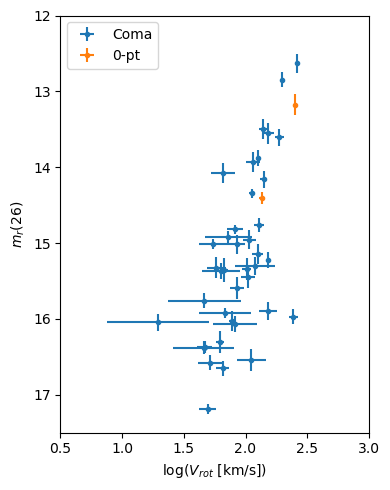

In [104]:
plt.figure(figsize=(4,5), tight_layout=True)

plt.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='Coma')

plt.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='0-pt')

plt.xlim([0.5, 3])
plt.ylim([17.5, 12])

plt.legend()

plt.xlabel('log($V_{rot}$ [km/s])')
plt.ylabel('$m_r (26)$');

# Compute the absolute magnitudes for the 0-pt calibrators based on the distance measurements

\begin{equation}
  M_r - 5\log h = m_r - \mu - 5\log h
\end{equation}
where $h$ is the reduced Hubble constant used to calibrate the distance modulus, $\mu$.

Both of our galaxies have distance moduli from Stahl et al. (2021), which *appears* to use $h = 1$.  Therefore, the distance moduli we have to use are $\mu_h = \mu - 5\log h$.

The third galaxy has a distance moduli from Pantheon+SH0ES, whose distances are based on distance ladder calibrations, so there is no assumption of $h$.

In [105]:
SGA_0pt['R_ABSMAG_SB26'] = SGA_0pt['R_MAG_SB26_CORR'] - SGA_0pt['DM1_SN'] #+ 5*np.log10(0.7)
SGA_0pt['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_0pt['R_MAG_SB26_ERR_CORR']**2 + SGA_0pt['e_DM1_SN']**2)

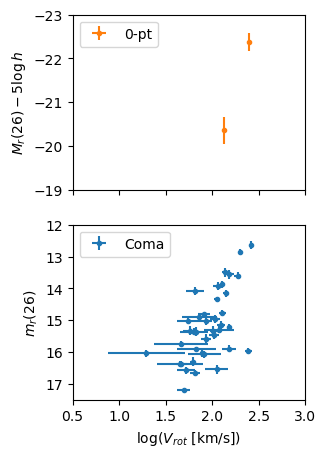

In [106]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(3,5))

ax2.errorbar(np.log10(SGA_TF['V_0p33R26']), 
             SGA_TF['R_MAG_SB26_CORR'], 
             xerr=0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'], 
             fmt='.', 
             label='Coma')

ax1.errorbar(np.log10(SGA_0pt['V_0p33R26']), 
             SGA_0pt['R_ABSMAG_SB26'], 
             xerr=0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26'],
             yerr=SGA_0pt['R_ABSMAG_SB26_ERR'], 
             fmt='.', 
             c='tab:orange',
             label='0-pt')

plt.xlim([0.5, 3])
ax1.set_ylim([-19, -23])
ax2.set_ylim([17.5, 12])

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.xlabel('log($V_{rot}$ [km/s])')
ax1.set_ylabel('$M_r (26) - 5\log h$')
ax2.set_ylabel('$m_r (26)$');

# Fit the TFR using the subclassed version of `hyperfit`

In [107]:
V0 = np.median(np.concatenate([np.log10(SGA_TF['V_0p33R26']), np.log10(SGA_0pt['V_0p33R26'])]))
print(V0)

2.0099088412865878


In [108]:
bounds_tfr = ((-20.0, 0.0), (0.0, 20.0), (-30.0, 0.0), (1.0e-5, 5.0))
# bounds_itfr = ((-20.0, 20.0), (0.0, 20.0), (-20.0, 0.0), (1.0e-5, 5.0))

results = hyperfit_line_multi([np.log10(SGA_TF['V_0p33R26']) - V0, np.log10(SGA_0pt['V_0p33R26']) - V0], 
                              [SGA_TF['R_MAG_SB26_CORR'], SGA_0pt['R_ABSMAG_SB26']],
                              [0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26'], 0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26']], 
                              [SGA_TF['R_MAG_SB26_ERR_CORR'], SGA_0pt['R_ABSMAG_SB26_ERR']], 
                              bounds_tfr, 
                              weights=[1/SGA_TF['MAX_VOL_FRAC'], 1/SGA_0pt['MAX_VOL_FRAC']]
                             )

a, b, sig_tfr, cov_tfr, tfr_mcmc_samples, hf_tfr = results

             message: Optimization terminated successfully.
             success: True
                 fun: -5355.305900587703
                   x: [-8.308e+00  1.500e+01 -1.921e+01  1.120e+00]
                 nit: 42
                nfev: 2605
          population: [[-8.308e+00  1.500e+01 -1.921e+01  1.119e+00]
                       [-8.287e+00  1.500e+01 -1.921e+01  1.116e+00]
                       ...
                       [-8.306e+00  1.500e+01 -1.920e+01  1.120e+00]
                       [-8.302e+00  1.500e+01 -1.922e+01  1.119e+00]]
 population_energies: [-5.355e+03 -5.355e+03 ... -5.355e+03 -5.355e+03]
                 jac: [ 4.666e-02  2.174e-02 -3.674e-02 -1.010e-02]
Ndim: 4 2


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 996.29it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [36.70684234 31.48387097 31.56650166 37.54594343] / 1877.2971715302174


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 997.17it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [44.53624637 34.73347391 36.18182794 44.66250922] / 2233.125461065261


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 998.69it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [37.15849283 35.11151886 35.74363165 40.58482121] / 2029.2410607134964


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.63it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [34.40237026 39.66014882 39.37910847 33.13421666] / 1983.0074412136278


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 961.43it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [41.30247203 45.36714387 43.39751023 39.36967342] / 2268.3571935443224


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.41it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.30643755 48.77860291 44.80037053 39.12160999] / 2438.9301455959753


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 997.03it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [42.78212974 51.89877244 48.7840889  40.56438744] / 2594.9386217658434


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 994.37it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [43.60164132 48.0724719  50.47416263 42.13507123] / 2523.708131326659


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 992.05it/s]


Niterations/Max Iterations:  9000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.14169833 49.44566335 48.76615727 46.08052797] / 2472.283167309175


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.78it/s]


Niterations/Max Iterations:  10000 / 100000
Integrated ACT/Min Convergence Iterations:  [48.39293965 46.74549574 48.37638338 43.45898513] / 2419.6469826981465


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 994.71it/s]


Niterations/Max Iterations:  11000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.84049855 48.53951055 46.70254809 46.15509666] / 2426.9755276729493


100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 993.37it/s]

Niterations/Max Iterations:  12000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.02427359 50.55671927 47.03120771 44.67235945] / 2527.8359635271086


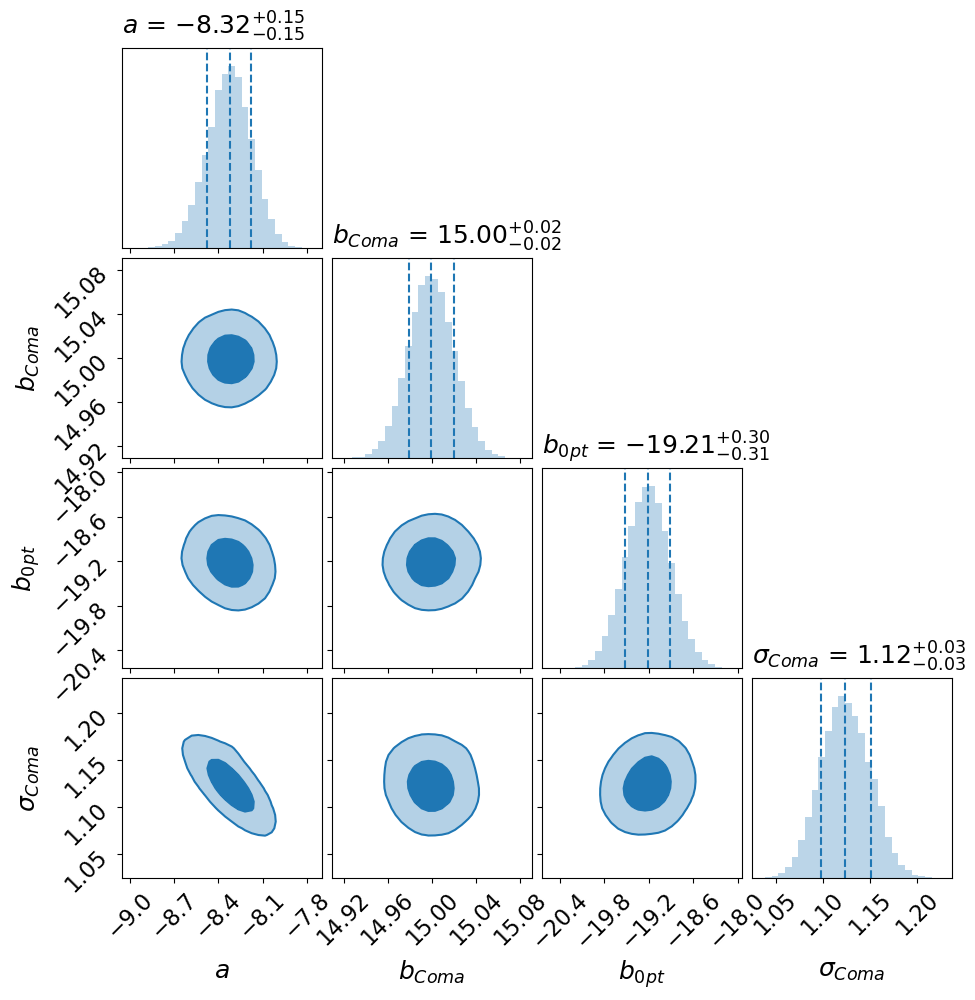

In [109]:
fig = corner.corner(tfr_mcmc_samples.T, bins=30, smooth=1,
                    # range=[[-0.14, -0.117], [1.9, 2.2], [-2.55, -2.15], [0.13, 0.15]],   # Range for w0, w1, sigma. Adjust as needed.
                    # range=[[-8.4, -7.2], [15.85, 16.1], [-18.6, -17.8], [1, 1.2]], # Range for a, b, sigma.  Adjust as needed.
                    # labels=['$w_0$', '$w_{1, Coma}$', '$w_{1, 0 pt}$', r'$\sigma_{Coma}$'],
                    labels=['$a$', '$b_{Coma}$', '$b_{0 pt}$', r'$\sigma_{Coma}$'],
                    label_kwargs={'fontsize':18}, 
                    labelpad=0.1, 
                    levels=(1-np.exp(-0.5), 1-np.exp(-2)),
                    quantiles=[0.16, 0.5, 0.84],
                    color='tab:blue',
                    hist_kwargs={'histtype':'stepfilled', 'alpha':0.3},
                    plot_datapoints=False,
                    fill_contours=True,
                    show_titles=True,
                    title_kwargs={"fontsize": 18, 'loc':'left', 'pad':10});

for ax in fig.get_axes():
    ax.tick_params(axis='both', which='major', labelsize=16)
'''
fig.savefig('../../Figures/SV/fuji_joint_Coma_corner_20250205.png', 
            dpi=150, 
            facecolor='none', 
            bbox_inches='tight')
''';

In [110]:
print(f'           slope:  {a:.2f} +/- {np.sqrt(cov_tfr[0,0]):.3f}')
print(f'y-intercept Coma:  {b[0]:.2f} +/- {np.sqrt(cov_tfr[1,1]):.3f}')
print(f' y-intercept 0pt: {b[1]:.2f} +/- {np.sqrt(cov_tfr[2,2]):.3f}')
print(f'         scatter:   {sig_tfr[0]:.2f} +/- {np.sqrt(cov_tfr[3,3]):.3f}')
print('-------')
print(f'   slope (alpha):  {-a/2.5:.2f} +/- {np.sqrt(cov_tfr[0,0])/2.5:.3f}')

           slope:  -8.32 +/- 0.151
y-intercept Coma:  15.00 +/- 0.021
 y-intercept 0pt: -19.21 +/- 0.307
         scatter:   1.12 +/- 0.026
-------
   slope (alpha):  3.33 +/- 0.061


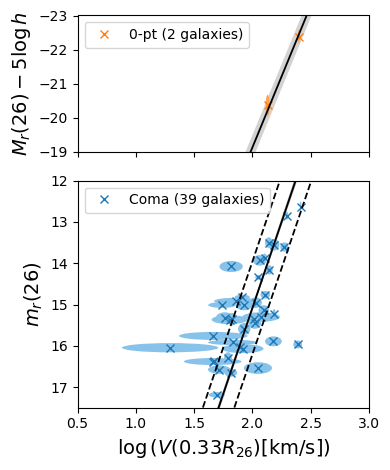

In [111]:
xvals = np.linspace(0.5, 3., 1000)
yvals = np.zeros((len(b), len(xvals)))
for i in range(len(b)):
    yvals[i] = a * (xvals - V0) + b[i]

################################################################################
# Get the MCMC 1-sigma quantiles to plot with the fit.
#-------------------------------------------------------------------------------
y_chain1 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[1]
y_chain1_quantiles = np.quantile(y_chain1, [0.1587, 0.8414], axis=1)

y_chain2 = np.outer(xvals - V0, tfr_mcmc_samples[0]) + tfr_mcmc_samples[2]
y_chain2_quantiles = np.quantile(y_chain2, [0.1587, 0.8414], axis=1)
################################################################################


################################################################################
# Pack info into data
#-------------------------------------------------------------------------------
data1 = [np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26_CORR']]
x1_err = 0.434*SGA_TF['V_0p33R26_ERR']/SGA_TF['V_0p33R26']
y1_err = SGA_TF['R_MAG_SB26_ERR_CORR']
corr1_xy = np.zeros_like(x1_err)

data2 = [np.log10(SGA_0pt['V_0p33R26']), SGA_0pt['R_ABSMAG_SB26']]
x2_err = 0.434*SGA_0pt['V_0p33R26_ERR']/SGA_0pt['V_0p33R26']
y2_err = SGA_0pt['R_ABSMAG_SB26_ERR']
corr2_xy = np.zeros_like(x2_err)
################################################################################


################################################################################
# Generate ellipses
#-------------------------------------------------------------------------------
ells1 = [
    Ellipse(
        xy=[data1[0][i], data1[1][i]],
        width=2*y1_err[i],
        height=2*x1_err[i],
        angle=np.rad2deg(np.arccos(corr1_xy[i])),
    )
    for i in range(len(data1[0]))
]

ells2 = [
    Ellipse(
        xy=[data2[0][i], data2[1][i]],
        width=2*y2_err[i],
        height=2*x2_err[i],
        angle=np.rad2deg(np.arccos(corr2_xy[i])),
    )
    for i in range(len(data2[0]))
]
################################################################################


################################################################################
# Make the plot
#-------------------------------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(2, 
                               figsize=(4,4.8), 
                               tight_layout=True, 
                               sharex=True, 
                               height_ratios=[3,5])

#-------------------------------------------------------------------------------
# Coma
#-------------------------------------------------------------------------------
ax2.fill_between(xvals, 
                 y_chain1_quantiles[0], 
                 y_chain1_quantiles[1], 
                 color="darkgray")

for i, e in enumerate(ells1):
    ax2.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:blue', amount=1.75))
    
ax2.plot(data1[0], data1[1], 'x', label='Coma ({} galaxies)'.format(len(SGA_TF)))

ax2.plot(xvals, yvals[0], c="k", marker="None", ls="-", lw=1.3)
ax2.plot(xvals, yvals[0] - sig_tfr[0], c="k", marker="None", ls="--", lw=1.3)
ax2.plot(xvals, yvals[0] + sig_tfr[0], c="k", marker="None", ls="--", lw=1.3)

ax2.set_xlabel(r"$\log{(V(0.33R_{26}) [\mathrm{km/s}])}$", fontsize=14)
ax2.set_ylabel(r"$m_r(26)$", fontsize=14)

ax2.legend(loc='upper left')

plt.xlim(0.5, 3)
ax2.set_ylim(17.5, 12)
#-------------------------------------------------------------------------------
# 0-pt calibrators
#-------------------------------------------------------------------------------
ax1.fill_between(xvals, 
                 y_chain2_quantiles[0], 
                 y_chain2_quantiles[1], 
                 color='lightgray')

for i, e in enumerate(ells2):
    ax1.add_artist(e)
    e.set_facecolor(adjust_lightness('tab:orange', amount=1.25))
    
ax1.plot(data2[0], 
         data2[1], 
         'x', 
         c='tab:orange',
         label='0-pt ({} galaxies)'.format(len(SGA_0pt)))

ax1.plot(xvals, yvals[1], c='k', marker='None', ls='-', lw=1.3)

ax1.set_ylabel(r'$M_r (26) - 5\log h$', fontsize=14)

ax1.legend(loc='upper left')

ax1.set_ylim(-19, -23);
#-------------------------------------------------------------------------------
################################################################################

# plt.savefig('../../Figures/SV/fuji_Coma_TFR_20240130.png', dpi=150)

# Does this calibration result in any dwarf galaxies?

Dwarf galaxies are defined as those below the line perpendicular to the calibration where $M_r > -17$.

## Define the line perpendicular to the calibration

In [112]:
logV_n17 = (-17 - b[1])/a + V0
b_perp = -17 + (logV_n17 - V0)/a
b_perp

np.float64(-16.96810964332776)

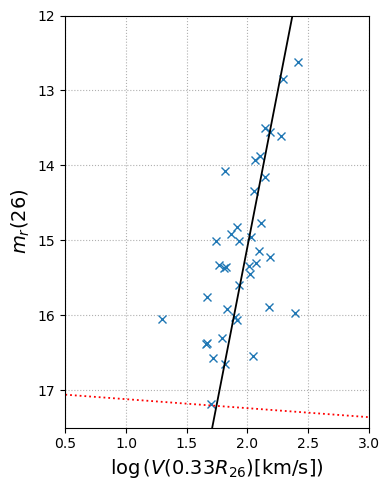

In [113]:
yvals_perp = -(xvals - V0)/a + (b_perp + b[0] - b[1])

################################################################################
# Make the plot
#-------------------------------------------------------------------------------
plt.figure(figsize=(4,5), tight_layout=True)

ax = plt.gca()

plt.grid(ls=':')

plt.plot(np.log10(SGA_TF['V_0p33R26']), SGA_TF['R_MAG_SB26_CORR'], 'x')

plt.plot(xvals, yvals[0], c='k', marker='None', ls='-', lw=1.3)
plt.plot(xvals, yvals_perp, c='r', marker='None', ls=':', lw=1.3)

plt.xlabel(r"$\log{(V(0.33R_{26}) [\mathrm{km/s}])}$", fontsize=14)
plt.ylabel(r'$m_r (26)$', fontsize=14)

plt.xlim(0.5, 3)
plt.ylim(17.5, 12);
################################################################################

## Filter out the dwarf galaxies

Those below the line
\begin{equation}
  m_r = -(\log(V(0.33R_{26})) - V_0)/a + b_\perp + (b_{Coma} - b_{0pt})
\end{equation}

In [114]:
dwarfs = (SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_MAG_SB26_ERR_CORR']) > (-(np.log10(SGA_TF['V_0p33R26']) - V0)/a + b_perp + b[0] - b[1])

SGA_TF_bright = SGA_TF[~dwarfs]

print(np.sum(dwarfs))

0


Looks like we have no "dwarf" galaxies, so we don't need to repeat the calibration.

In [115]:
temp_outfile = open('cov_ab_fuji_joint_TFR_varyV0-perpdwarfs0_AnthonyUpdates_weightsVmax-1_dVsys_corr_KAD-20260114.pickle', 'wb')
pickle.dump((cov_tfr, tfr_mcmc_samples, V0), temp_outfile)
temp_outfile.close()